# Data Download

Using cURL instead of Kaggle cause kagglehub only downloads to outside your project directory and Kaggle needs authentification...
 
uhhhe, gross!

In [22]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/sobhanmoosavi/us-accidents

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  653M  100  653M    0     0  41.2M      0  0:00:15  0:00:15 --:--:-- 41.6M


In [26]:
!unzip archive.zip

Archive:  archive.zip
  inflating: US_Accidents_March23.csv  


# Data Cleaning

## Drop Variables

I'll use pyspark first cause it's optimized for large data. By the end of the section we will output a pandas dataframe which is more familiar to everybody.

In [8]:
import pyspark as ps
import pandas as pd

In [9]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("US_Accidents_Analysis").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/10/23 12:08:24 WARN Utils: Your hostname, Aegis resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/10/23 12:08:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/23 12:08:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("US_Accidents_Analysis").getOrCreate()

# Load the CSV file into a DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").csv("US_Accidents_March23.csv")


In [11]:
df.printSchema()


root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [12]:
df.show(5)

24/10/23 12:08:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

Some of the variables simply don't make sense and will not contribute to our model.

In [13]:
# Drop the unnecessary columns including ID and Source
df_cleaned = df.drop("Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", "ID", "Source")

# Show the first 5 rows of the cleaned DataFrame to verify the columns were removed
df_cleaned.show(5, truncate=False)

+--------+-------------------+-------------------+------------+-------------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|Start_Time         |End_Time           |Distance(mi)|Street                   |City        |County    |State|Zipcode   |Country|Timezone  |Airport_Code|Weather_Timestamp  |Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump |Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop |Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Tw

In [14]:
df.count()

7728394

In [16]:
df = df_cleaned
df.show(5, truncate = False)

+--------+-------------------+-------------------+------------+-------------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|Start_Time         |End_Time           |Distance(mi)|Street                   |City        |County    |State|Zipcode   |Country|Timezone  |Airport_Code|Weather_Timestamp  |Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump |Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop |Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Tw

## Explore Zipcode as a categorical variable

In [7]:
from pyspark.sql.functions import substring

# Extract the first five digits of the zip codes
df_first_five = df.withColumn("Zipcode_5", substring("Zipcode", 1, 5))

# Count distinct first five digits of the zip codes
unique_zipcode_5_count = df_first_five.select("Zipcode_5").distinct().count()

# Show the unique first five digits of the zip codes
print(f"Number of unique first five-digit zip codes: {unique_zipcode_5_count}")

NameError: name 'df' is not defined

In [41]:
from pyspark.sql.functions import count

# Group by the first five digits of the zip code and count the occurrences
df_zipcode_histogram = df_first_five.groupBy("Zipcode_5").agg(count("*").alias("count"))

# Display the top 10 zip codes by frequency
df_zipcode_histogram.orderBy("count", ascending=False).show(10, truncate=False)

+---------+-----+
|Zipcode_5|count|
+---------+-----+
|27610    |12907|
|33186    |11952|
|32819    |11894|
|91761    |11455|
|70808    |10971|
|28205    |10797|
|91706    |10556|
|28208    |10411|
|27604    |10185|
|37211    |9931 |
+---------+-----+
only showing top 10 rows



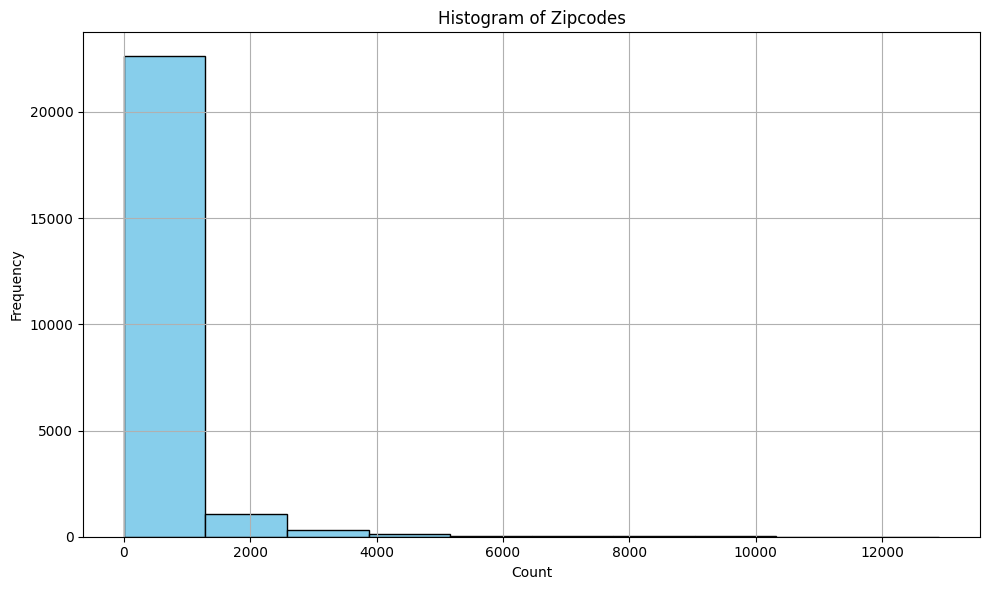

In [43]:
df_zipcode_histogram_pd = df_zipcode_histogram.toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_zipcode_histogram_pd['count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Zipcodes')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Explore (City, County, State) Combo as a categorical variable

In [11]:
from pyspark.sql.functions import concat, col, lit, count

# Step 1: Create a unique city-county-state combination column and rename it as "Location"
df_location = df.withColumn("Location", concat(col("City"), lit(", "), col("County"), lit(", "), col("State")))

# Step 2: Group by the "Location" column and count the occurrences
df_location_histogram = df_location.groupBy("Location").agg(count("*").alias("count"))

# Step 3: Order by count in descending order and limit to the top 10 for display
df_location_histogram.orderBy("count", ascending=False).show(10, truncate=False)

+---------------------------------+------+
|Location                         |count |
+---------------------------------+------+
|Miami, Miami-Dade, FL            |186760|
|Houston, Harris, TX              |168826|
|Los Angeles, Los Angeles, CA     |156491|
|Charlotte, Mecklenburg, NC       |138325|
|Dallas, Dallas, TX               |128115|
|Orlando, Orange, FL              |109687|
|Austin, Travis, TX               |93402 |
|Raleigh, Wake, NC                |86043 |
|Nashville, Davidson, TN          |72666 |
|Baton Rouge, East Baton Rouge, LA|71587 |
+---------------------------------+------+
only showing top 10 rows



In [37]:
df_location_histogram.orderBy("count", ascending=True).show(10, truncate=False)

+----------------------------+-----+
|Location                    |count|
+----------------------------+-----+
|Tiro, Crawford, OH          |1    |
|Smithville, McCurtain, OK   |1    |
|Woodridge, Sullivan, NY     |1    |
|Sadorus, Champaign, IL      |1    |
|Reagan, Chester, TN         |1    |
|Marine City, Saint Clair, MI|1    |
|Walker, Linn, IA            |1    |
|Swansea, Saint Clair, IL    |1    |
|Tenaha, Panola, TX          |1    |
|Madison, Putnam, GA         |1    |
+----------------------------+-----+
only showing top 10 rows



In [19]:
unique_location_count = df_location_histogram.select("Location").distinct().count()

# Print the count of unique locations
print(f"Number of unique locations: {unique_location_count}")

Number of unique locations: 25069


In [14]:
df_location_histogram_pd = df_location_histogram.toPandas()

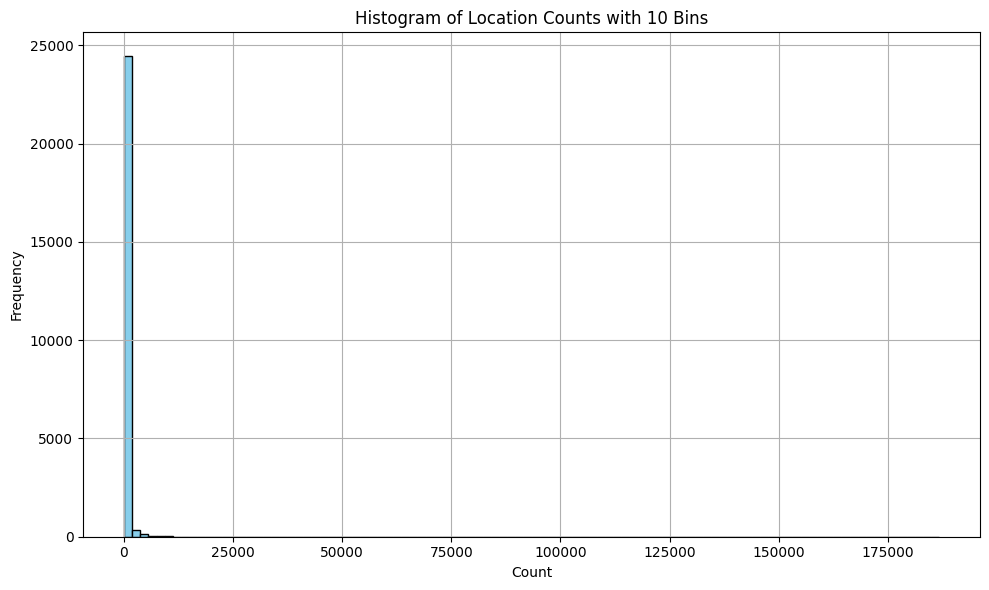

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the boxplot of the counts using seaborn
plt.figure(figsize=(10, 6))
plt.hist(df_location_histogram_pd['count'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Location Counts with 10 Bins')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Explore discretized (Start_Lat, Start_Lng) as a Category Variable

In [21]:
from pyspark.sql.functions import round

# Step 1: Round the Start_Lat and Start_Lng to integers
df_rounded = df.withColumn("Rounded_Lat", round(col("Start_Lat")).cast("int")) \
               .withColumn("Rounded_Lng", round(col("Start_Lng")).cast("int"))

# Step 2: Create a combined column for Lat and Lng
df_lat_lng_combo = df_rounded.withColumn("Lat_Lng_Combo", concat(col("Rounded_Lat"), lit(", "), col("Rounded_Lng")))

# Step 3: Group by the Lat_Lng_Combo column and count the occurrences
df_lat_lng_histogram = df_lat_lng_combo.groupBy("Lat_Lng_Combo").agg(count("*").alias("count"))

# Step 4: Show the unique combinations and their counts
df_lat_lng_histogram.orderBy("count", ascending=False).show(10, truncate=False)

+-------------+------+
|Lat_Lng_Combo|count |
+-------------+------+
|34, -118     |654761|
|26, -80      |309510|
|41, -74      |280057|
|38, -122     |222212|
|33, -97      |202455|
|39, -77      |199757|
|35, -81      |169856|
|42, -88      |152732|
|30, -95      |137799|
|40, -75      |132091|
+-------------+------+
only showing top 10 rows



In [22]:
unique_lat_lng_count = df_lat_lng_histogram.select("Lat_Lng_Combo").distinct().count()

# Print the count of unique latitude-longitude combinations
print(f"Number of unique rounded latitude-longitude combinations: {unique_lat_lng_count}")


Number of unique rounded latitude-longitude combinations: 904


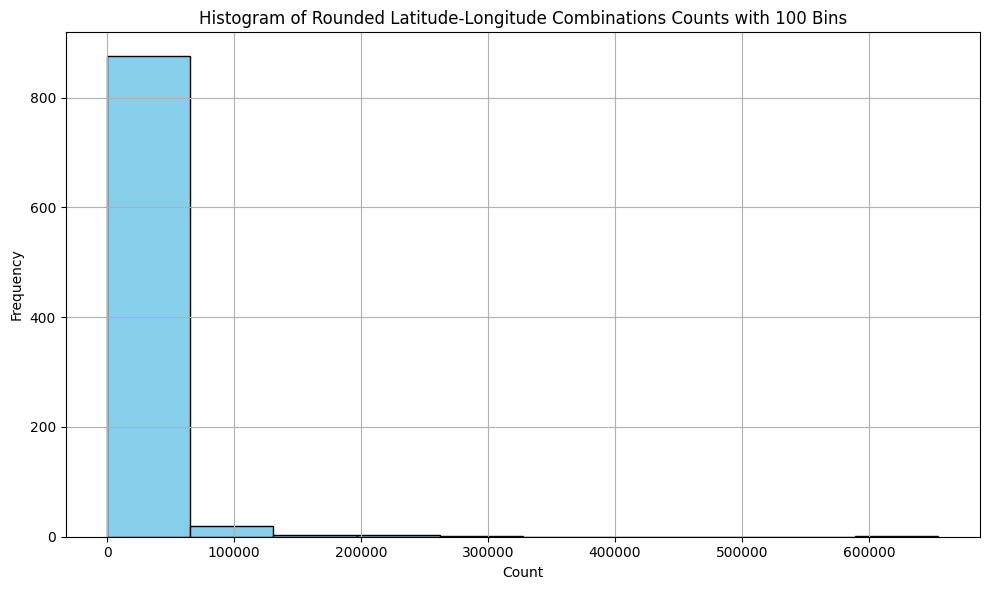

In [24]:
df_lat_lng_histogram_pd = df_lat_lng_histogram.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_lat_lng_histogram_pd['count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Rounded Latitude-Longitude Combinations Counts with 100 Bins')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

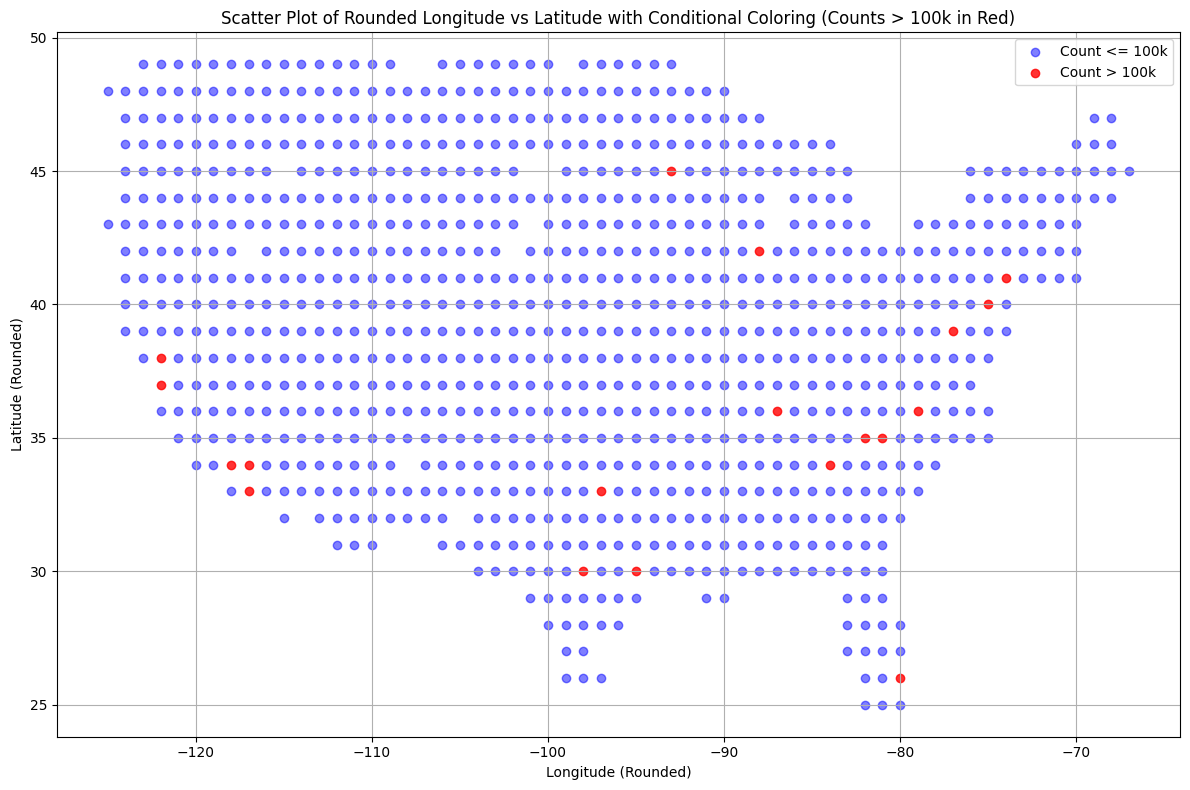

In [34]:
from pyspark.sql.functions import round, count, col

# Step 1: Round the Start_Lat and Start_Lng to integers
df_rounded = df.withColumn("Rounded_Lat", round(col("Start_Lat")).cast("int")) \
               .withColumn("Rounded_Lng", round(col("Start_Lng")).cast("int"))

# Step 2: Group by the Rounded_Lat and Rounded_Lng columns and count the occurrences
df_lat_lng_count = df_rounded.groupBy("Rounded_Lat", "Rounded_Lng").agg(count("*").alias("count"))

# Step 3: Convert the PySpark DataFrame to a Pandas DataFrame for plotting
df_lat_lng_count_pd = df_lat_lng_count.toPandas()

# Step 4: Split the data into two parts: above and below the 100k threshold
df_above_100k = df_lat_lng_count_pd[df_lat_lng_count_pd['count'] > 100000]
df_below_100k = df_lat_lng_count_pd[df_lat_lng_count_pd['count'] <= 100000]

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Step 5: Plot the points below 100,000 using a blue color
plt.figure(figsize=(12, 8))
plt.scatter(df_below_100k['Rounded_Lng'], df_below_100k['Rounded_Lat'], 
            color='blue', alpha=0.5, label='Count <= 100k')

# Step 6: Plot the points above 100,000 in red
plt.scatter(df_above_100k['Rounded_Lng'], df_above_100k['Rounded_Lat'], 
            color='red', alpha=0.8, label='Count > 100k')

# Step 7: Add labels, title, and legend
plt.xlabel('Longitude (Rounded)')
plt.ylabel('Latitude (Rounded)')
plt.title('Scatter Plot of Rounded Longitude vs Latitude with Conditional Coloring (Counts > 100k in Red)')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Hexbin Plot

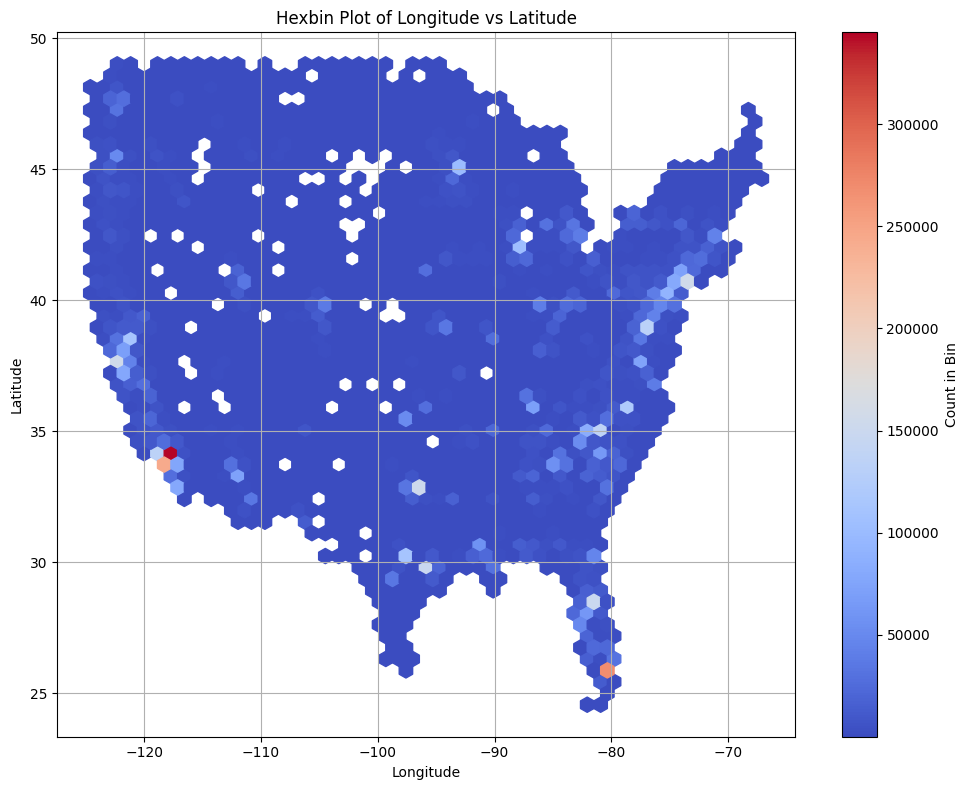

In [35]:
# Step 1: Convert the PySpark DataFrame to a Pandas DataFrame for plotting
df_pd = df.select("Start_Lat", "Start_Lng").toPandas()

# Step 2: Plot the hexbin plot
plt.figure(figsize=(10, 8))
plt.hexbin(df_pd['Start_Lng'], df_pd['Start_Lat'], gridsize=50, cmap='coolwarm', mincnt=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hexbin Plot of Longitude vs Latitude')
plt.colorbar(label='Count in Bin')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Get Population by Zipcode

In [6]:
import requests

# Base URL for the Census ACS 2022 Profile API
BASE_URL = "https://api.census.gov/data/2022/acs/acs5/profile"

def get_population_data(zip_code):
    # Constructing the parameters for the API call
    params = {
        "get": "group(DP05)",  # Requesting demographic group data (e.g., population)
        "ucgid": f"860Z200US{zip_code}"
    }

    try:
        # Make the GET request to the Census API
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()  # Check for any HTTP errors
        
        # Parse the JSON response
        data = response.json()

        # Extract the population value from data[1][0]
        if len(data) > 1 and len(data[1]) > 0:
            population = data[1][0]  # Extract the value from data[1][0]
            print(f"Population for ZIP code {zip_code}: {population}")
            return int(population)
        else:
            print(f"No valid data found for ZIP code {zip_code}.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

# Example usage
zip_code = "30332"  # Replace with the desired ZIP code
population = get_population_data(zip_code)


Population for ZIP code 30332: 2743
